In [1]:
import numpy as np
import os
from astropy.io import fits
from scipy.spatial import Delaunay, cKDTree
from scipy.interpolate import LinearNDInterpolator
from numpy.lib.recfunctions import append_fields
import emcee
from multiprocessing import Pool
from astropy.io import fits

In [2]:
# Loading the data
data = fits.getdata('../data/Elbadry_200pc_binaries_v2_ruwe_a0_prior.fits')
data = data.view(np.recarray)
data = append_fields(data,"phot_g_mean_mag_error",np.divide(1.086,data.phot_g_mean_flux_over_error),
                     usemask=False, asrecarray=True)
data = append_fields(data,"phot_g_mean_mag_error2",np.divide(1.086,data.phot_g_mean_flux_over_error2),
                     usemask=False, asrecarray=True)
data = append_fields(data,"phot_rp_mean_mag_error",np.divide(1.086,data.phot_rp_mean_flux_over_error),
                     usemask=False, asrecarray=True)
data = append_fields(data,"phot_rp_mean_mag_error2",np.divide(1.086,data.phot_rp_mean_flux_over_error2),
                     usemask=False, asrecarray=True)
data = append_fields(data,"phot_bp_mean_mag_error",np.divide(1.086,data.phot_bp_mean_flux_over_error),
                     usemask=False, asrecarray=True)
data = append_fields(data,"phot_bp_mean_mag_error2",np.divide(1.086,data.phot_bp_mean_flux_over_error2),
                     usemask=False, asrecarray=True)
data = append_fields(data,"parallax_error",np.divide(1,data.parallax_over_error)*data.parallax,
                     usemask=False, asrecarray=True)
data = append_fields(data,"parallax_error2",np.divide(1,data.parallax_over_error2)* data.parallax2,
                     usemask=False, asrecarray=True)

# Add new fields:
array = np.zeros(len(data))
components = ["","2"]

quality_names = ['mean_acceptance_fraction']

percentiles = ["","_lower","_upper"]
field_names = ['lnprob','teff','logg','feh','mass','age','a0','logl']
array_list = []
name_list = []
for component in components:
    for quality_name in quality_names:
        array_list.append(array)
        name_list.append(quality_name + component)
    for field_name in field_names:
        for percentile in percentiles:
            array_list.append(array)
            name_list.append(field_name + percentile + component)
data = append_fields(data,name_list,array_list,usemask=False, asrecarray=True)
print(len(data), data.dtype)
# correct for the G magnitude systematic error
g_corr = np.copy(data.phot_g_mean_mag)
cut = (data.phot_g_mean_mag <= 6)
g_corr[cut] = data.phot_g_mean_mag[cut] + 0.0271 * ( 6 - data.phot_g_mean_mag[cut])
cut = (data.phot_g_mean_mag > 16)
g_corr[cut] = data.phot_g_mean_mag[cut] - 0.032
cut = (data.phot_g_mean_mag <= 16) & (data.phot_g_mean_mag > 6)
g_corr[cut] = data.phot_g_mean_mag[cut] - (0.0032 * (data.phot_g_mean_mag[cut]-6))
data.phot_g_mean_mag = g_corr

g_corr = np.copy(data.phot_g_mean_mag2)
cut = (data.phot_g_mean_mag2 <= 6)
g_corr[cut] = data.phot_g_mean_mag2[cut] + 0.0271 * ( 6 - data.phot_g_mean_mag2[cut])
cut = (data.phot_g_mean_mag2 > 16)
g_corr[cut] = data.phot_g_mean_mag2[cut] - 0.032
cut = (data.phot_g_mean_mag2 <= 16) & (data.phot_g_mean_mag2 > 6)
g_corr[cut] = data.phot_g_mean_mag2[cut] - (0.0032 * (data.phot_g_mean_mag2[cut]-6))
data.phot_g_mean_mag2 = g_corr
# correct for the underestimated internal parallax uncertainty
def external_uncertainty(internal_uncertainty):
    k = 1.08
    sigma_s = 0.043
    return(np.sqrt( k**2 * internal_uncertainty**2 + sigma_s**2))
data.parallax_error = external_uncertainty(data.parallax_error)
data.parallax_error2 = external_uncertainty(data.parallax_error2)

# correct for the zero parallax offset
data.parallax += 0.05
data.parallax2 += 0.05

# increase minimum photometric noise to 0.03
#data.phot_g_mean_mag_error[(data.phot_g_mean_mag_error<0.03)] = 0.03

55507 (numpy.record, [('source_id2', '>i8'), ('ra2', '>f8'), ('dec2', '>f8'), ('astrometric_chi2_al_2', '>f8'), ('astrometric_n_good_obs_al2', '>i8'), ('phot_g_mean_flux_over_error2', '>f8'), ('phot_rp_mean_flux_over_error2', '>f8'), ('phot_bp_mean_flux_over_error2', '>f8'), ('phot_bp_rp_excess_factor2', '>f8'), ('pmra2', '>f8'), ('pmra_error2', '>f8'), ('pmdec2', '>f8'), ('pmdec_error2', '>f8'), ('phot_g_mean_mag2', '>f8'), ('phot_bp_mean_mag2', '>f8'), ('phot_rp_mean_mag2', '>f8'), ('parallax2', '>f8'), ('parallax_over_error2', '>f8'), ('radial_velocity2', '>f8'), ('radial_velocity_error2', '>f8'), ('rv_nb_transits2', '>i8'), ('source_id', '>i8'), ('ra', '>f8'), ('dec', '>f8'), ('pmra', '>f8'), ('pmra_error', '>f8'), ('pmdec', '>f8'), ('pmdec_error', '>f8'), ('phot_g_mean_mag', '>f8'), ('phot_bp_mean_mag', '>f8'), ('phot_rp_mean_mag', '>f8'), ('parallax', '>f8'), ('parallax_over_error', '>f8'), ('astrometric_chi2_al', '>f8'), ('astrometric_n_good_obs_al', '>i8'), ('phot_g_mean_flux_o

In [3]:
def get_error(gmag,gmagerror,parallax,parallaxerror,rpmag,rpmagerror):
    #propagate both errors
    abs_g = np.random.normal(gmag,gmagerror,1000) + 5 * np.log10(np.divide(np.random.normal(parallax,parallaxerror,1000),100))
    gd = np.mean(abs_g)
    ge = np.std(abs_g) 
    # BPRP error
    c = np.random.normal(gmag,gmagerror,1000) - np.random.normal(rpmag,rpmagerror,1000)
    cd = np.mean(c)
    ce = np.std(c)
    return(gd,ge,cd,ce)

# We have to define a log likelihood it measures how well the model fits the data (just multiplication of 2 Gaussians)
def lnlikelihood(g_model,g_data,g_error,c_model,c_data,c_error):
    '''
    this is an unnormalised ln likelihood function
    '''
    g_like = -1*((g_model - g_data)**2)/(2*g_error**2)
    c_like = -1*((c_model - c_data)**2)/(2*c_error**2)
    return(g_like + c_like)


def query(interpolator, parameter1, parameter2, parameter3):
    '''
    This queries the stellar model for 'spectroscopic' the input is:
        log_teff, logg, feh
    For 'physical' the input is:
        mass, log_age, feh
    Returns:
        G and G-GRP
    Appends the respective other parameters to the result
    For 'physical' these are log_teff and logg
    For 'spectroscopic' these are mass and log_age
    '''
    result = interpolator([parameter1,parameter2,parameter3])[0]
    result = np.hstack((result[:2],result[-3:]))
    return(result)

def query_with_extinction(interpolator, parameter1, parameter2, parameter3, extinction, band_interpolation = 'linear'):
    '''
    This queries the stellar model for 'spectroscopic' the input is:
        log_teff, logg, feh
    For 'physical' the input is:
        mass, log_age, feh
    Returns:
        G and G-GRP
    If return_other than the respective other stellar astrophysical parameters are appended to the return:
    For 'physical' these are log_teff and logg
    For 'spectroscopic' these are mass and log_age
    band_interpolation: 'linear' is 50 times faster, 'cubic' is more accurate. For low extinction (< 6) the linear should be a good approximation
    '''                
    av_axis = np.array([0,1,2,3,5,10])        
    rs = interpolator([parameter1,parameter2,parameter3])[0]
    g = np.array([rs[0],rs[2],rs[4],rs[6],rs[8],rs[10]])
    grp = np.array([rs[1],rs[3],rs[5],rs[7],rs[9],rs[11]])
    if band_interpolation == 'linear':
        gres = np.interp(extinction,av_axis,g)
        grpres = np.interp(extinction,av_axis,grp)
    elif band_interpolation == 'cubic':
        from scipy.interpolate import interp1d                
        gres = interp1d(av_axis,g, kind = 'cubic', copy = False, bounds_error=False, fill_value='extrapolate', assume_sorted = True)(extinction)           
        grpres = interp1d(av_axis,grp, kind = 'cubic', copy = False, bounds_error=False, fill_value='extrapolate', assume_sorted = True)(extinction)           
    result = np.hstack((gres,grpres,rs[-3:]))
    return(result)



def initialize_mcmc(index_g_color, isochrones, g, color, nwalkers):
    """
    This function returns the closest parsec models in observable space (G,BP-RP)
    and returns the initial walker positions for the MCMC containing mass, age and feh of the #walkers closest models
    INPUT:
       index_g_color = KDTree of the parsec models in abs_g and bp-rp
       isochrones = the parsec isochrones as downloaded
       g = abs_g of the star
       color = color of the star
       nwalkers = number of closest models to look for in order to initialise that number of walkers
    
    OUTPUT:
       p0 = the stacked array for MCMC initialization where for each walker mass, age and feh information of the model are given.
    """
    cut = index_g_color.query(np.c_[g,color],nwalkers)[1][0]
    log_teff = isochrones[cut].log_teff
    log_grav = isochrones[cut].log_grav
    meh_ini = isochrones[cut].meh_ini
    log_teff += np.random.normal(0,0.02,size = nwalkers)
    log_grav += np.random.normal(0,0.02,size = nwalkers)
    meh_ini += np.random.normal(0,0.02,size = nwalkers)
    return(np.c_[log_teff,log_grav,meh_ini])

def imf(mass):
    """
    IMF prior    
    """
    result = 0
    if mass < 1:
        result = np.power(mass,-1.6)
    elif mass >= 1:
        result = np.power(mass,-3.0)
    if mass < 0.08 or mass > 50:
        result = -np.inf
    result = np.log(result)
    if np.isnan(result):
        result = -np.inf
    return(result)


def sfr(log_age):
    """
    flat prior in linear age
    """
    result = 0
    if log_age > 10.12 or log_age < 6.6:
        return(-np.inf)
    else:
        age = np.power(10,log_age)
        # Jakobian factor
        result = np.divide(age,np.log10(np.exp(1)))
        return(np.log(result))

def mdf(feh):
    """
    flat prior for now
    """
    result = 0
    if feh > 0.33 or feh < -1.5:
        result = -np.inf
    return(result)

def prior(mass,log_age,feh):
    lnmass = imf(mass)
    lnage = sfr(log_age)
    lnfeh = mdf(feh)
    return(lnmass + lnage + lnfeh)

def lnprob(x, ivar):
    gd,ge,cd,ce = ivar
    log_teff,log_grav,meh_ini = x
    gm,cm,log_mass,log_age,log_lum = query(interp,log_teff, log_grav, meh_ini)
    mass = np.power(10,log_mass)
    lnlike = lnlikelihood(gm,gd,ge,cm,cd,ce)
    lnprior = prior(mass,log_age,meh_ini)
    
    if np.isnan(lnlike):
        lnlike = -np.inf
    if np.isnan(lnprior):
        lnprior = -np.inf
    return(lnlike + lnprior, np.hstack((mass,log_age,log_lum)))

def printout(d, component,sampler):
    d["mean_acceptance_fraction" + component] = np.median(sampler.acceptance_fraction)
    d["teff" + component] = np.power(10,np.percentile(sampler.get_chain(flat=True)[:,0],50))
    d["teff_lower" + component] = np.power(10,np.percentile(sampler.get_chain(flat=True)[:,0],16))
    d["teff_upper" + component] = np.power(10,np.percentile(sampler.get_chain(flat=True)[:,0],84))
    d["logg" + component] = np.percentile(sampler.get_chain(flat=True)[:,1],50)
    d["logg_lower" + component] = np.percentile(sampler.get_chain(flat=True)[:,1],16)
    d["logg_upper" + component] = np.percentile(sampler.get_chain(flat=True)[:,1],84)
    d["feh" + component] = np.percentile(sampler.get_chain(flat=True)[:,2],50)
    d["feh_lower" + component] = np.percentile(sampler.get_chain(flat=True)[:,2],16)
    d["feh_upper" + component] = np.percentile(sampler.get_chain(flat=True)[:,2],84)
    d["mass" + component] = np.percentile(sampler.get_blobs(flat=True)[:,0],50)
    d["mass_lower" + component] = np.percentile(sampler.get_blobs(flat=True)[:,0],16)
    d["mass_upper" + component] = np.percentile(sampler.get_blobs(flat=True)[:,0],84)
    d["age" + component] = np.power(10,np.percentile(sampler.get_blobs(flat=True)[:,1],50))/1e9
    d["age_lower" + component] = np.power(10,np.percentile(sampler.get_blobs(flat=True)[:,1],16))/1e9
    d["age_upper" + component] = np.power(10,np.percentile(sampler.get_blobs(flat=True)[:,1],84))/1e9
    d["logl" + component] = np.percentile(sampler.get_blobs(flat=True)[:,2],50)
    d["logl_lower" + component] = np.percentile(sampler.get_blobs(flat=True)[:,2],16)
    d["logl_upper" + component] = np.percentile(sampler.get_blobs(flat=True)[:,2],84)
    d["lnprob" + component] = np.percentile(sampler.get_log_prob(flat=True),50)
    d["lnprob_lower" + component] = np.percentile(sampler.get_log_prob(flat=True),16)
    d["lnprob_upper" + component] = np.percentile(sampler.get_log_prob(flat=True),84)
    return(d)

In [4]:
pa = fits.getdata("../data/isochrones/reduced/parsec_dr3_original_sparse_feh_20th.fits")
pa = pa.view(np.recarray)
input_grid = np.c_[pa.log_teff,pa.log_grav,pa.meh_ini]
output_grid = np.c_[pa.g0,pa.grp0,pa.g1,pa.grp1,pa.g2,pa.grp2,pa.g3,pa.grp3,pa.g5,pa.grp5,pa.g10,pa.grp10,pa.log_mass,pa.log_age,pa.log_lum]
grid = Delaunay(input_grid)
print("tesselation finished")
interp = LinearNDInterpolator(grid,output_grid, rescale = False)
print("interpolator ready")
# Initialization: in order to pick the first parsec models to start MCMC from
init_parsec_index = cKDTree(np.c_[pa.g0,pa.grp0])
print("initialisation tree")

tesselation finished
interpolator ready
initialisation tree


In [5]:

###
def make_entry(i):
    components = ["","2"]
    ndim, nwalkers = 3, 6
    try:
        for component in components:
            # First component
            ivar = get_error(data["phot_g_mean_mag" + component][i],data["phot_g_mean_mag_error" + component][i],
                             data["parallax" + component][i],data["parallax_error" + component][i], 
                             data["phot_rp_mean_mag" + component][i], data["phot_rp_mean_mag_error" + component][i])
            # Initialization with models that are closest in observable space
            p0 = initialize_mcmc(init_parsec_index, pa, ivar[0], ivar[2], nwalkers)

            sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ivar])
            
            pos, prob, state, blobs = sampler.run_mcmc(p0, 1)
            sampler.reset()
            sampler.run_mcmc(pos, 2001)

            data[i] = printout(data[i],component, sampler)
            #for item in ['lnprob','teff','logg','feh','mass','age','a0']:
            #    print(item,data[i][item + component])
    except Exception as e:
        print('simple initialisation failed')
        print(repr(e))
        try:
            for component in components:
                # First component
                ivar = get_error(data["phot_g_mean_mag" + component][i],data["phot_g_mean_mag_error" + component][i],
                                 data["parallax" + component][i],data["parallax_error" + component][i], 
                                 data["phot_rp_mean_mag" + component][i], data["phot_rp_mean_mag_error" + component][i])
                # 1)Random initialization
                p0_ind = np.random.choice(len(pa),replace = False, size = nwalkers)
                p0= np.c_[pa[p0_ind]['log_teff'],pa[p0_ind]['log_grav'],pa[p0_ind]['meh_ini']]

                sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[ivar])
                pos, prob, state, blobs = sampler.run_mcmc(p0, 2000)

                sampler.reset()
                sampler.run_mcmc(pos, 101)

                data[i] = printout(data[i],component, sampler)
        except Exception as e:
            print('random initialisation also failed. No results for binary with index: ', i)
            print(repr(e))
            return(data[i])
    return(data[i], sampler) 

/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log


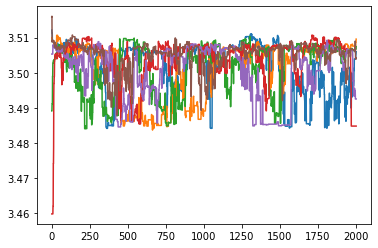

/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log
/home/rybizki/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


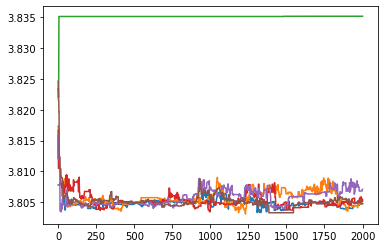

/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log


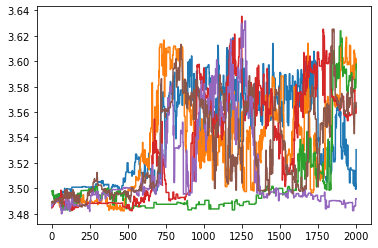

/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log


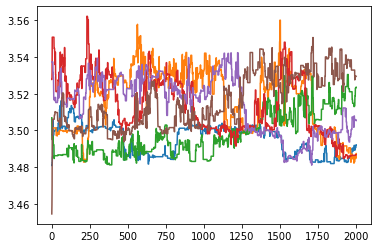

/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log


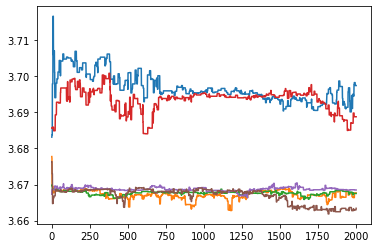

/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log


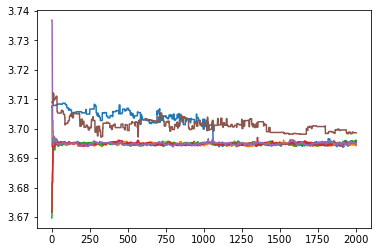

/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log
/home/rybizki/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


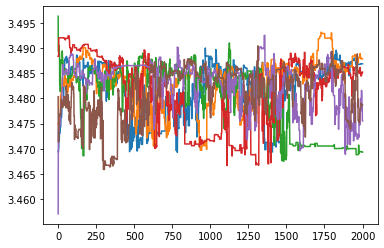

/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log
/home/rybizki/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


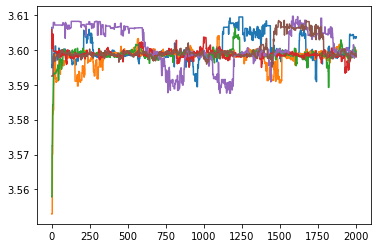

/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log


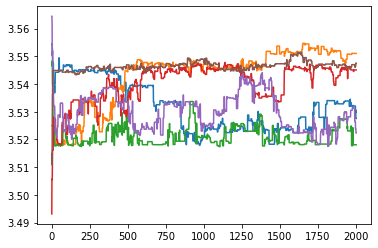

/home/rybizki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log


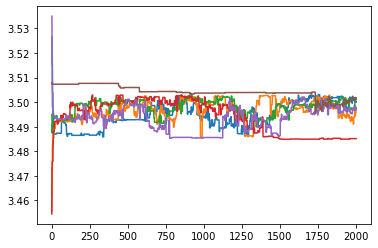

In [6]:
#%timeit make_entry(10)

import matplotlib.pyplot as plt
for j in range(10):
    d,s = make_entry(j)
    for i in range(6):
        plt.plot(s.chain[i,:,0])
    plt.show()


In [7]:
break

pool = Pool(processes = None)
result = pool.map(make_entry, range(len(data)))

for j in range(len(data)):
    data[j] = result[j]

SyntaxError: 'break' outside loop (<ipython-input-7-c92c607517c7>, line 4)

In [ ]:
print(data[0])

In [ ]:
fits.writeto("../data/value_added_3params_spectroscopic.fits",data)